In [10]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
#from torchvision import datasets
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [11]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    #plt.title('y = ' + str(data_sample[1]))

In [12]:
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
 
# image transformations- defining how make image into a tensor
transformp = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
trainset = dsets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transformp)

testset = dsets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transformp)

print(len(trainset))
trainloader = DataLoader(dataset=trainset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(dataset=testset, batch_size = BATCH_SIZE, shuffle = True)
print(len(trainloader))

60000
469


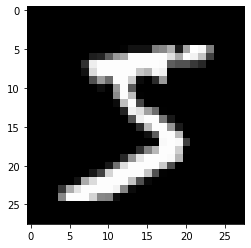

In [14]:
show_data(trainset[0])

In [15]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
#where store reconstructed images 
def make_dir():
    image_dir = 'MNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
#saves reconstructed image 
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './MNIST_Images/linear_ae_image{}.png'.format(epoch))

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        # encoder- five layers
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder- 5 layers
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
 
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
 
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
 
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [17]:
criterion = nn.MSELoss()#define loss function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [18]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            # the _ would be an output lable but autoencoder soo
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)#flatten image into 1D
            #next four lines are taking an optimization step
            optimizer.zero_grad()#clears the the old gradients from the last step
            outputs = net(img)#runs data on the net
            loss = criterion(outputs, img)# calc the loss
            loss.backward()#claclates the ger of the loss using brack prop
            optimizer.step()#take step based on the gradient
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        #saving image after every five epochs
        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)
    # this is the loss after one epoch
    return train_loss

In [19]:
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'mnist_reconstruction.png')
        show_data(outputs)#idk why this is only showing one image
        break

In [ ]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)
 
make_dir()
 
# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')
plt.show()
 


cpu
Epoch 1 of 50, Train Loss: 0.923
Epoch 2 of 50, Train Loss: 0.917
Epoch 3 of 50, Train Loss: 0.911
Epoch 4 of 50, Train Loss: 0.907
Epoch 5 of 50, Train Loss: 0.904


In [ ]:
# test the network
test_image_reconstruction(net, testloader)
print('hi')